# ✅ Step 1: Dataset Preprocessing & Exploratory Analysis

## 📦 Mount Google Drive & Set Paths

In [1]:
# Set path to the videos
video_dir = '/content/drive/MyDrive/Chicks'
output_frames_dir = '/content/Chick_Frames'

## 📦 Create Folder to Store Extracted Frames

In [2]:
import os

os.makedirs(output_frames_dir, exist_ok=True)


## 📦 Extract Frames from Videos (Downsample to 5 fps to reduce redundancy)

In [3]:
import cv2
def extract_frames(video_path, output_folder, fps_skip=6):
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % fps_skip == 0:
            resized = cv2.resize(frame, (224, 224))  # standard input size
            save_path = os.path.join(output_folder, f"{video_name}_frame_{saved_count:04d}.png")
            cv2.imwrite(save_path, resized)
            saved_count += 1
        frame_count += 1
    cap.release()

# Extract all
video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi'))]
for vid in video_files:
    extract_frames(os.path.join(video_dir, vid), output_frames_dir)


## 📦 Apply Preprocessing (CLAHE (Contrast Limited Adaptive Histogram Equalization) + Gaussian Blur)

In [4]:
import numpy as np
from tqdm import tqdm

def preprocess_frame(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # assume thermal = grayscale
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image)
    # Gaussian Blur
    image = cv2.GaussianBlur(image, (3, 3), 0)
    return image

# Apply to all
preprocessed_dir = '/content/Preprocessed_Frames'
os.makedirs(preprocessed_dir, exist_ok=True)

frame_files = [f for f in os.listdir(output_frames_dir) if f.endswith('.png')]
for file in tqdm(frame_files):
    frame = preprocess_frame(os.path.join(output_frames_dir, file))
    cv2.imwrite(os.path.join(preprocessed_dir, file), frame)


100%|██████████| 3103/3103 [00:10<00:00, 286.99it/s]


## 📈 Preview Few Preprocessed Frames

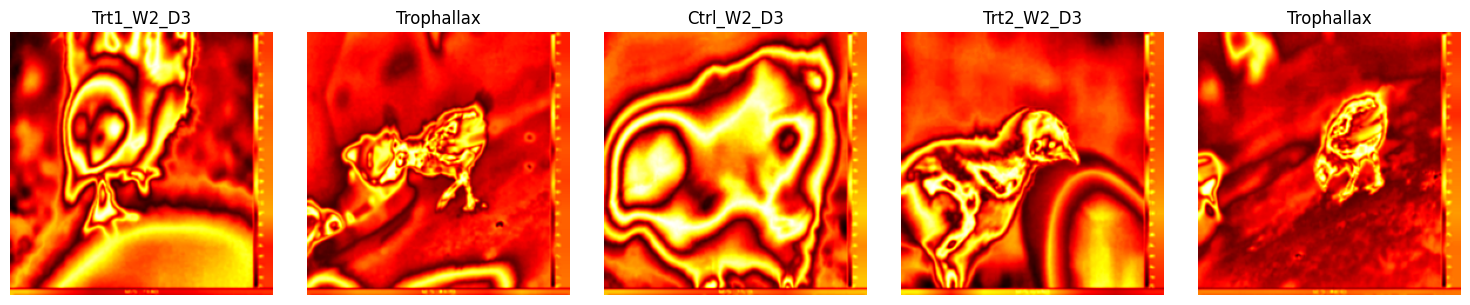

In [5]:
import matplotlib.pyplot as plt

sample_imgs = frame_files[:5]
plt.figure(figsize=(15, 3))
for idx, img_name in enumerate(sample_imgs):
    img = cv2.imread(os.path.join(preprocessed_dir, img_name), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img, cmap='hot')
    plt.title(img_name[:10])
    plt.axis('off')
plt.tight_layout()
plt.show()


# ✅ Frame Quality Check & Diagnostics (Colab Code)

## 📦 Load and Visualize Random Frames

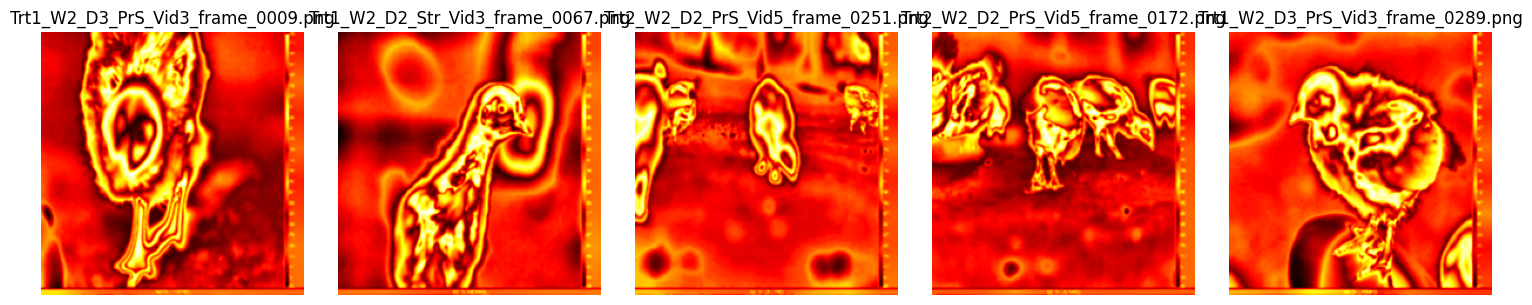

In [6]:
import matplotlib.pyplot as plt
import random
import cv2
import os

def show_random_frames(folder, n=5):
    files = [f for f in os.listdir(folder) if f.endswith('.png')]
    sample_files = random.sample(files, n)

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(sample_files):
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='hot')
        plt.title(file)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_frames(preprocessed_dir)


## 📦 Histogram Analysis of Frame Brightness Distribution

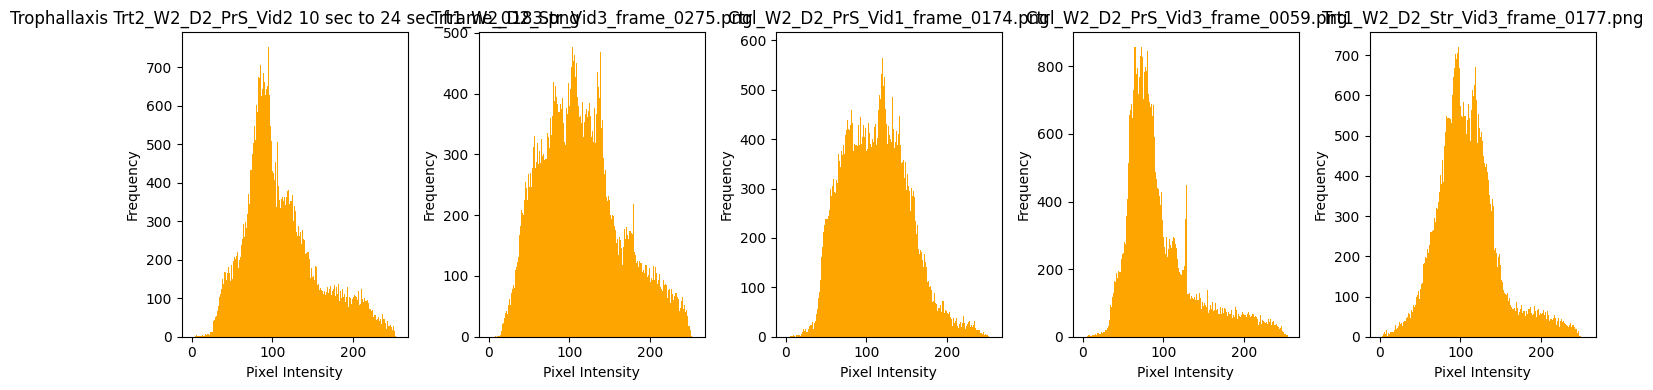

In [7]:
def plot_histograms(folder, n=5):
    files = [f for f in os.listdir(folder) if f.endswith('.png')]
    sample_files = random.sample(files, n)

    plt.figure(figsize=(15, 4))
    for i, file in enumerate(sample_files):
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.hist(img.ravel(), bins=256, range=[0, 256], color='orange')
        plt.title(file)
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_histograms(preprocessed_dir)


## 📦 Check for Low Contrast Frames (automated flagging)

In [8]:
def flag_low_contrast(folder, threshold=15.0):
    files = [f for f in os.listdir(folder) if f.endswith('.png')]
    low_contrast_files = []

    for file in files:
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
        contrast = img.std()
        if contrast < threshold:
            low_contrast_files.append((file, contrast))

    print(f"Low contrast frames found: {len(low_contrast_files)}")
    for file, c in low_contrast_files[:10]:
        print(f"{file} - Std Dev: {c:.2f}")

flag_low_contrast(preprocessed_dir)


Low contrast frames found: 0


## 📦 Temporal Brightness Variance Check (for flickering or inconsistent exposure)

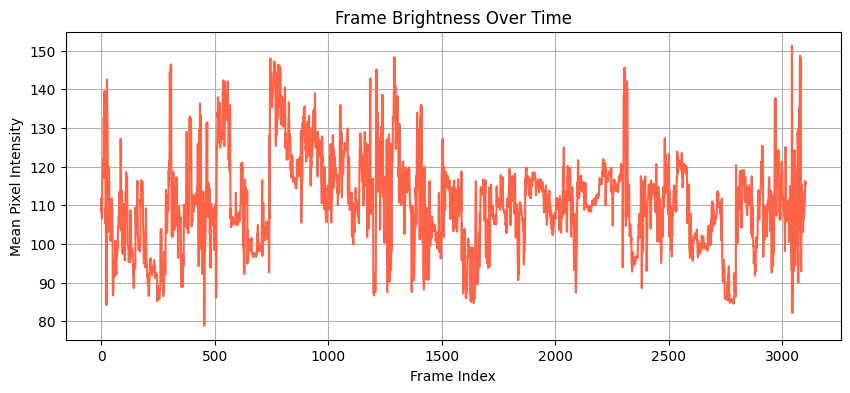

In [9]:
import numpy as np

def brightness_variance(folder):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.png')])
    mean_intensities = []

    for file in files:
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
        mean_intensities.append(np.mean(img))

    plt.figure(figsize=(10, 4))
    plt.plot(mean_intensities, color='tomato')
    plt.title('Frame Brightness Over Time')
    plt.xlabel('Frame Index')
    plt.ylabel('Mean Pixel Intensity')
    plt.grid(True)
    plt.show()

brightness_variance(preprocessed_dir)


## 📦 Plot and Check Random Frames

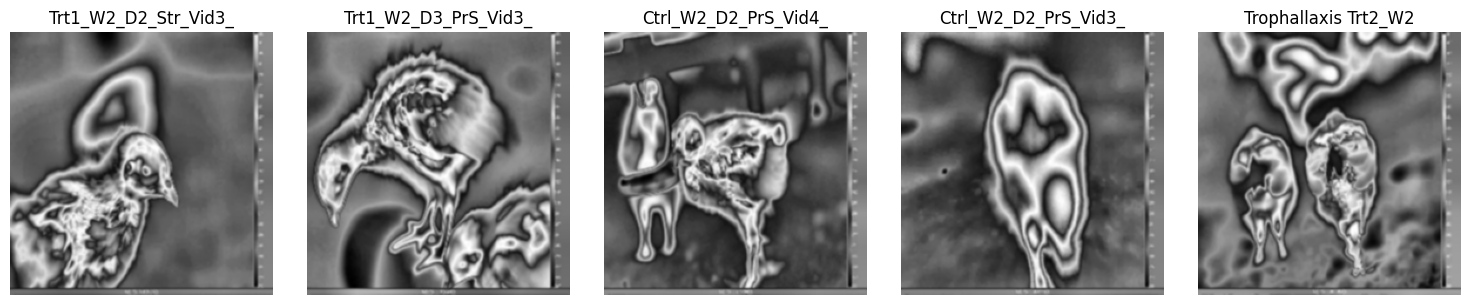

In [10]:
import cv2
import matplotlib.pyplot as plt
import os
import random

# Set the preprocessed folder path
preprocessed_dir = '/content/Preprocessed_Frames'

# Load and plot random frames
def plot_ready_to_feed(folder, num=5):
    files = [f for f in os.listdir(folder) if f.endswith('.png')]
    selected = random.sample(files, num)

    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(selected):
        path = os.path.join(folder, fname)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Resize check
        assert img.shape == (224, 224), f"Size mismatch: {fname} has shape {img.shape}"

        # Type conversion
        img_float = img.astype('float32') / 255.0  # normalize to [0, 1]

        # Plot
        plt.subplot(1, num, i + 1)
        plt.imshow(img_float, cmap='gray')
        plt.title(fname[:20])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_ready_to_feed(preprocessed_dir)


# 🧠 SimCLR Self-Supervised Learning Pipeline (automated Labelling)|


## 📦 Prepare Folder Structure for ImageFolder

In [11]:
import os
import shutil

# Move all frames into a dummy subfolder to use with ImageFolder
source_dir = '/content/Preprocessed_Frames'
target_dir = '/content/Chick_Thermal_Data/class_placeholder'

os.makedirs(target_dir, exist_ok=True)

for file in os.listdir(source_dir):
    if file.endswith('.png'):
        shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))

print(f"Moved {len(os.listdir(target_dir))} frames to ImageFolder-compatible structure.")


Moved 3103 frames to ImageFolder-compatible structure.



## 📦 SimCLR Transform Class

In [12]:
import torchvision.transforms as transforms

class SimCLRTransform:
    def __init__(self, size=224):
        self.base_transform = transforms.Compose([
            transforms.RandomResizedCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)


## 📦 Load Dataset

In [13]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = SimCLRTransform()
dataset = ImageFolder(root='/content/Chick_Thermal_Data', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


## 📦 Define SimCLR Model

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimCLRModel(nn.Module):
    def __init__(self, out_dim=128):
        super(SimCLRModel, self).__init__()
        base_model = models.resnet18(pretrained=False)
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projector(h)
        return z


## 📦 Contrastive Loss (NT-Xent)

In [15]:
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.5):
    z = F.normalize(torch.cat([z_i, z_j], dim=0), dim=1)
    sim = torch.matmul(z, z.T) / temperature

    batch_size = z_i.size(0)
    labels = torch.arange(batch_size, device=z.device)
    labels = torch.cat([labels, labels], dim=0)

    # Remove self-similarity
    mask = torch.eye(2 * batch_size, device=z.device).bool()
    sim.masked_fill_(mask, -9e15)

    positives = torch.cat([torch.diag(sim, batch_size), torch.diag(sim, -batch_size)])
    nominator = torch.exp(positives)
    denominator = torch.sum(torch.exp(sim), dim=1)
    loss = -torch.log(nominator / denominator).mean()
    return loss


## 📦 Train for One Batch (Test Run)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):  # ← optional: add epochs
    total_loss = 0
    for step, batch in enumerate(dataloader):
        x_i, x_j = batch[0]
        x_i, x_j = x_i.to(device), x_j.to(device)

        z_i = model(x_i)
        z_j = model(x_j)

        loss = nt_xent_loss(z_i, z_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        #print(f"Epoch {epoch+1} | Step {step+1} | Loss: {loss.item():.4f}")

    print(f"✅ Epoch {epoch+1} completed — Avg Loss: {total_loss / len(dataloader):.4f}")


✅ Epoch 1 completed — Avg Loss: 4.1111
✅ Epoch 2 completed — Avg Loss: 4.1047
✅ Epoch 3 completed — Avg Loss: 4.0703
✅ Epoch 4 completed — Avg Loss: 4.0214
✅ Epoch 5 completed — Avg Loss: 3.8890
✅ Epoch 6 completed — Avg Loss: 3.7598
✅ Epoch 7 completed — Avg Loss: 3.6650
✅ Epoch 8 completed — Avg Loss: 3.5918
✅ Epoch 9 completed — Avg Loss: 3.5101
✅ Epoch 10 completed — Avg Loss: 3.4544


## 📦 Step 3.6: Extract Features for Visualization

In [25]:
model.eval()
features = []

with torch.no_grad():
    for batch in dataloader:
        x, _ = batch
        x = x[0].to(device)
        z = model(x)
        features.append(z.cpu().numpy())

features = np.concatenate(features, axis=0)


## 📦 Step 3.7: Visualize with t-SNE + KMeans

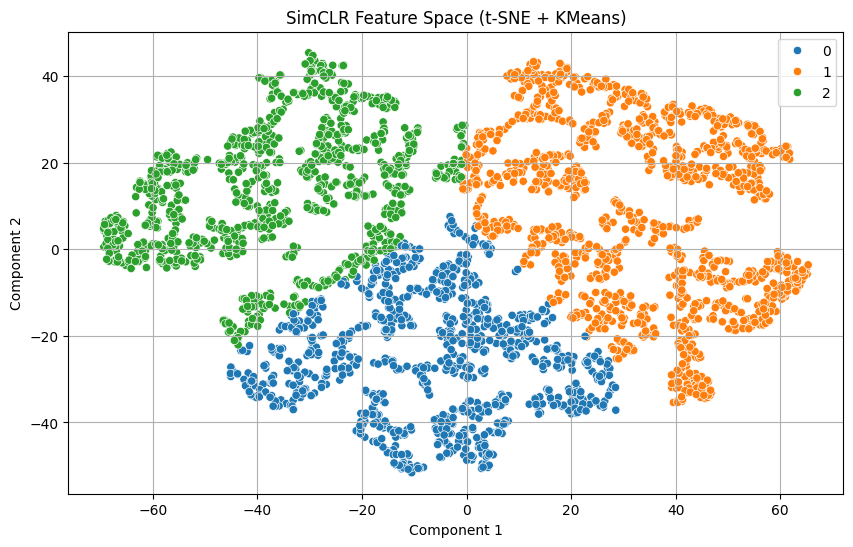

In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(tsne_results)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette='tab10')
plt.title("SimCLR Feature Space (t-SNE + KMeans)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()


# 🔧 Autoencoder-Based Anomaly Detection

## 📦 Autoencoder Architecture

In [19]:
import torch
import torch.nn as nn

class ThermalAutoencoder(nn.Module):
    def __init__(self):
        super(ThermalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 56x56
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 28x28
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 224x224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


##  📦 Prepare Dataset (Single View, No Augmentation)

In [20]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

ae_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

ae_dataset = ImageFolder('/content/Chick_Thermal_Data', transform=ae_transform)
ae_loader = DataLoader(ae_dataset, batch_size=16, shuffle=True)


## 📦 Train Autoencoder on "Normal" Thermal Patterns

In [21]:
model_ae = ThermalAutoencoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

model_ae.train()
for epoch in range(25):  # more epochs = better recon
    total_loss = 0
    for batch in ae_loader:
        imgs, _ = batch
        imgs = imgs.to(device)

        recon = model_ae(imgs)
        loss = loss_fn(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 2.3753
Epoch 2 | Loss: 0.3847
Epoch 3 | Loss: 0.2614
Epoch 4 | Loss: 0.2046
Epoch 5 | Loss: 0.1757
Epoch 6 | Loss: 0.1463
Epoch 7 | Loss: 0.1326
Epoch 8 | Loss: 0.1162
Epoch 9 | Loss: 0.1041
Epoch 10 | Loss: 0.0989
Epoch 11 | Loss: 0.0892
Epoch 12 | Loss: 0.0837
Epoch 13 | Loss: 0.0814
Epoch 14 | Loss: 0.0748
Epoch 15 | Loss: 0.0707
Epoch 16 | Loss: 0.0646
Epoch 17 | Loss: 0.0645
Epoch 18 | Loss: 0.0619
Epoch 19 | Loss: 0.0640
Epoch 20 | Loss: 0.0513
Epoch 21 | Loss: 0.0528
Epoch 22 | Loss: 0.0497
Epoch 23 | Loss: 0.0516
Epoch 24 | Loss: 0.0463
Epoch 25 | Loss: 0.0461


## 📦 Evaluate and Visualize Reconstruction Errors

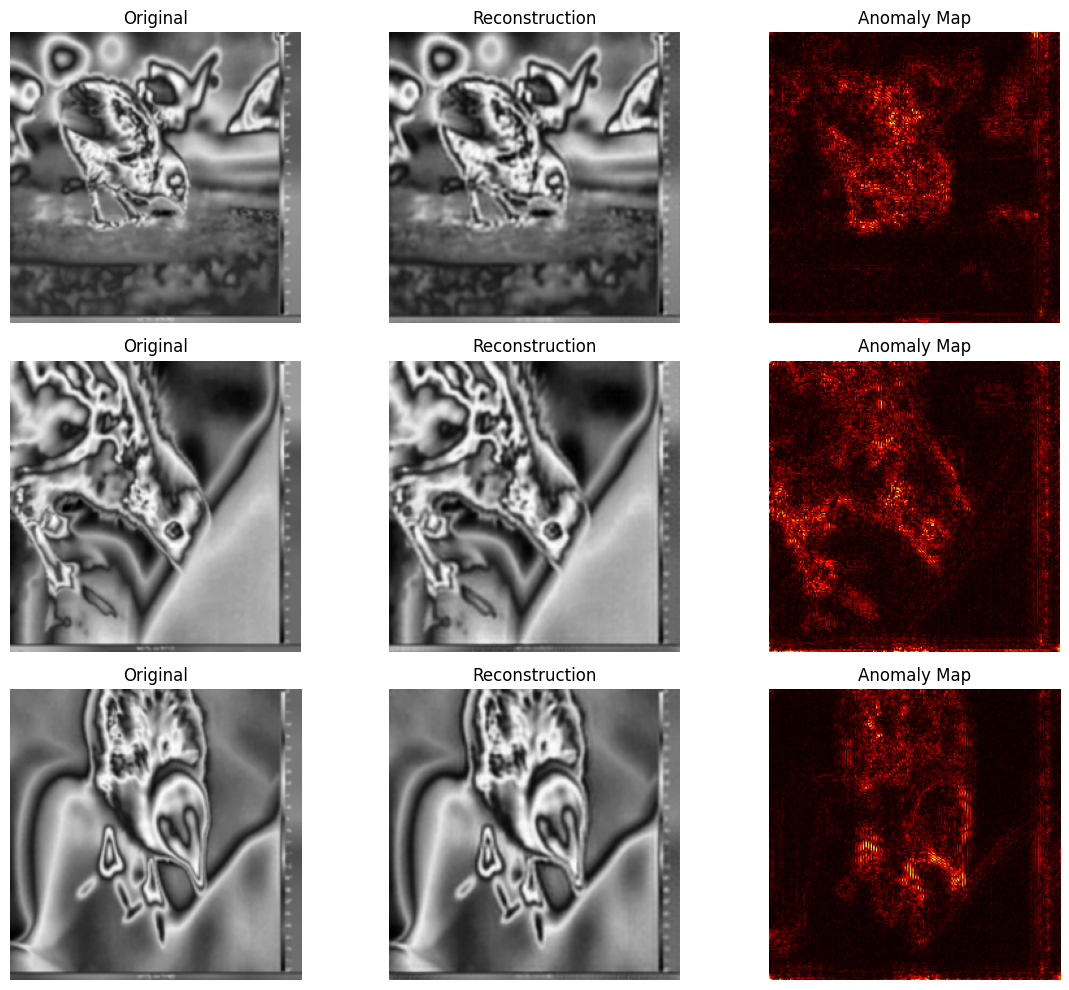

In [22]:
import matplotlib.pyplot as plt
import numpy as np

model_ae.eval()
imgs, _ = next(iter(ae_loader))
imgs = imgs.to(device)
with torch.no_grad():
    recons = model_ae(imgs)

errors = torch.mean((recons - imgs) ** 2, dim=[1, 2, 3])  # per-frame error

# Show top 3 anomalies (highest reconstruction error)
top_anomalies = torch.topk(errors, 3).indices

plt.figure(figsize=(12, 10))
for i, idx in enumerate(top_anomalies):
    original = imgs[idx].cpu().squeeze()
    recon = recons[idx].cpu().squeeze()
    diff = torch.abs(original - recon)

    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(recon, cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(diff, cmap='hot')
    plt.title("Anomaly Map")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

model_ae.eval()
anomaly_scores = []

with torch.no_grad():
    for batch in tqdm(ae_loader):
        imgs, _ = batch
        imgs = imgs.to(device)
        recons = model_ae(imgs)

        # Mean Squared Error per frame
        errors = torch.mean((recons - imgs) ** 2, dim=[1, 2, 3])
        anomaly_scores.extend(errors.cpu().numpy())


100%|██████████| 194/194 [00:04<00:00, 39.95it/s]


In [ ]:
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

overlay_dir = "/content/anomaly_overlays"
os.makedirs(overlay_dir, exist_ok=True)

model_ae.eval()

with torch.no_grad():
    for idx, (batch, _) in enumerate(ae_loader):
        batch = batch.to(device)
        recon = model_ae(batch)

        for i in range(batch.size(0)):
            original = batch[i].cpu().squeeze().numpy()
            output = recon[i].cpu().squeeze().numpy()
            diff = np.abs(original - output)

            # Normalize anomaly map to [0, 255]
            anomaly_map = (diff / diff.max() * 255).astype(np.uint8)
            anomaly_colored = cv2.applyColorMap(anomaly_map, cv2.COLORMAP_JET)

            # Convert original to RGB
            original_rgb = cv2.cvtColor((original * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

            # Combine side by side
            combined = np.hstack((original_rgb, anomaly_colored))
            filename = f"{overlay_dir}/frame_{idx * batch.size(0) + i:04d}.png"
            cv2.imwrite(filename, combined)


In [ ]:
import imageio

output_video = "/content/anomaly_detection_overlay.mp4"
frame_files = sorted([os.path.join(overlay_dir, f) for f in os.listdir(overlay_dir) if f.endswith(".png")])
frames = [imageio.imread(f) for f in frame_files]

imageio.mimsave(output_video, frames, fps=5)  # change fps as needed


<ipython-input-33-3819731b537a>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(f) for f in frame_files]
